By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the ANTIPASTI model is explained.

In [1]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import CenteredNorm

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.optim import LBFGS
from torch.nn import MSELoss
from torchmetrics import PearsonCorrCoef

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import create_test_set, save_checkpoint, training_routine

# Pre-processing

In [2]:
modes = 30 # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = False # True to retrieve again all the chain lengths 
mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
regions = 'paired_hl' # 'paired_hl' or 'heavy'
#pathological = ['3etb', '3gkz', '3lrh', '3t0w', '3t0x', '3uze', '3uzq', '4f9l', '4gqp', '4k3h', '6d6t']
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
preprocessed_data = Preprocessing(modes=modes, regions=regions, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, mode=mode)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

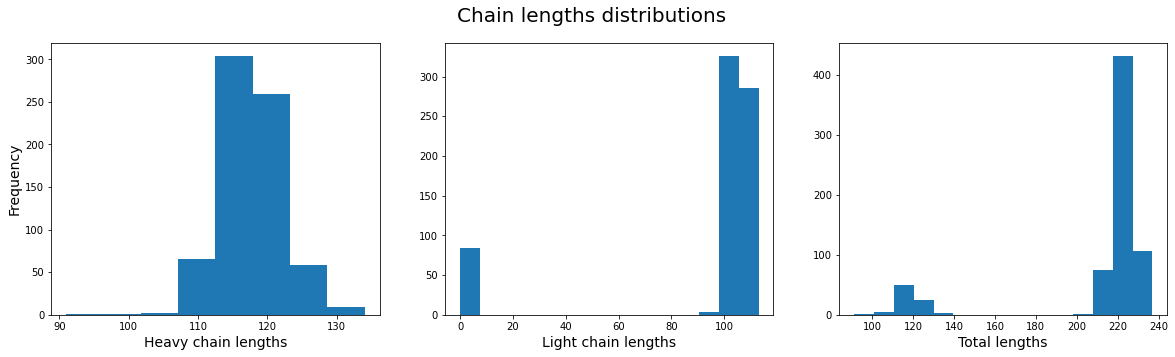

In [3]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Frequency', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

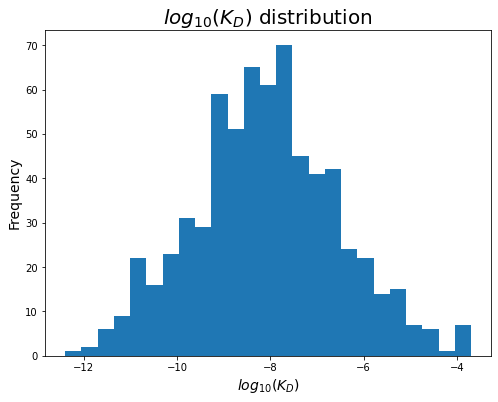

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Frequency', size=font_size)
plt.show()

In [5]:
test_pdbs = ['2nz9', '5vpg', '6a0z', '3g5y', '5dd0', '3u0t', '1zv5', '4w6w', '3l95', '1oay', '1m7d', '2hkf', '6eyo', '2p44', '5i8c', '4odx']
ix = []
for l in test_pdbs:
    ix.append(preprocessed_data.labels.index(l))

In [6]:
ix.sort()
ix

[44, 62, 91, 116, 141, 146, 216, 250, 284, 388, 409, 470, 501, 573, 603, 648]

A sample normal mode correlation map before and after adding the blank pixels.

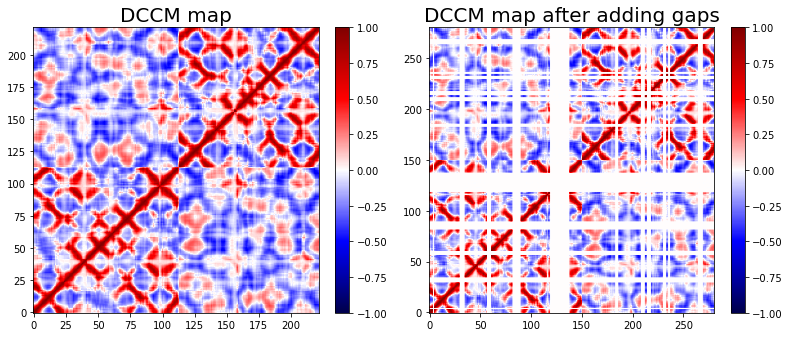

In [7]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[74], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[74].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

plt.colorbar(im1, ax=ax1, fraction=0.045)
plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [8]:
# The test set is generated
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(preprocessed_data.train_x, preprocessed_data.train_y)

In [9]:
# Hyperparameters
n_filters = 2
filter_size = 4
pooling_size = 1
learning_rate = 0.00027253018778843 * 0.2

# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape)
criterion = MSELoss() #-PearsonCorrCoef()
#optimiser = LBFGS(model.parameters(), lr=1e-3, history_size=10)
optimiser = AdaBelief(model.parameters(), lr=learning_rate, eps=1e-8, print_change_log=False) 

print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
ANTIPASTI(
  (conv1): Conv2d(1, 2, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=154568, out_features=1, bias=False)
)


In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
#{'learning_rate': 0.00027253018778843, 'n_max_epochs': 65, 'pooling_size': 1, 'filter_size': 4, 'n_filters': 4}
#{'learning_rate': 0.0008657756272162166, 'n_max_epochs': 82, 'pooling_size': 1, 'filter_size': 5, 'n_filters': 1}. Best is trial 30 with value: 1.0617385705312092.

# Training

In [120]:
train_losses = []
test_losses = []

In [88]:
model.train()
n_max_epochs = 23 * 6
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4893, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor([[-7.5858]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4392]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor([[-7.4195]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5992]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.3113]], grad_fn=<MmBackward0>)
tenso

tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor([[-7.3717]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4250]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.5020]], grad_fn=<MmBackward0>)
tenso

tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor([[-7.3303]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.0254]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.2046]], grad_fn=<MmBackward0>)
tenso

tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4888, grad_fn=<MulBackward0>)
tensor(0.4892, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4893, grad_fn=<MulBackward0>)
tensor(0.4893, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4893, grad_fn=<MulBackward0>)
tensor(0.4896, grad_fn=<MulBackward0>)
tensor([[-7.9371]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6288]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4893, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor([[-7.8684]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.9971]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4894, grad_fn=<MulBackward0>)
tensor(0.4898, grad_fn=<MulBackward0>)
tensor(0.4898, grad_fn=<MulBackward0>)
tensor(0.4896, grad_fn=<MulBackward0>)
tensor(0.4894, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor([[-7.1605]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.2465]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor([[-9.5494]], grad_fn=<MmBackward0>)
tensor([[-10.6990]])
------------------------
tensor([[-7.5348]], grad_fn=<MmBackward0>)
tensor([[-6.5086]])
------------------------
tensor([[-7.3647]], grad_fn=<MmBackward0>)
tensor([[-6.8125]])
------------------------
tensor([[-8.3047]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-6.2495]], grad_fn=<MmBackward0>)
tensor([[-7.6990]])
------------------------
tensor([[-7.0858]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.7788]], grad_fn=<MmBackward0>)
tensor([[-8.6861]])
------------------------
tensor([[-7.8869]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.7217]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
Epoch :  28 	 train loss:  1.1203130485452881 train MSE:  tensor(0.6188, grad_fn=<AddBackward0>) test MSE:  0.7796086686214636
Corr: 0.7945396929428638
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, g

tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor([[-6.9073]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4507]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.1724]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-10.1201]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------

Corr: 0.8271531047678159
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor([[-7.0064]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3611]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
---------

tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4869, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4867, grad_fn=<MulBackward0>)
tensor([[-7.5285]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5030]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

Corr: 0.8318205338919863
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor([[-7.2677]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4408]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
---------

tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4892, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor([[-7.6881]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6474]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.5212]], grad_fn=<MmBackward0>)
tenso

tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4888, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor([[-7.3590]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4161]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor([[-7.3999]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5759]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor([[-7.3540]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4850]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

Corr: 0.8138582379989326
tensor(0.4869, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor([[-7.4472]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.9330]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
---------

tensor([[-8.2804]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.0013]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-9.1842]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-9.4934]], grad_fn=<MmBackward0>)
tensor([[-10.6990]])
------------------------
tensor([[-7.3877]], grad_fn=<MmBackward0>)
tensor([[-6.5086]])
------------------------
tensor([[-7.3864]], grad_fn=<MmBackward0>)
tensor([[-6.8125]])
------------------------
tensor([[-8.4372]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-6.1388]], grad_fn=<MmBackward0>)
tensor([[-7.6990]])
------------------------
tensor([[-7.4469]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.6185]], grad_fn=<MmBackward0>)
tensor([[-8.6861]])
------------------------
tensor([[-7.9355]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.8102]], grad_fn=<Mm

tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor([[-7.3326]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6826]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor([[-7.8834]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.7500]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
Epoch :  74 	 train loss:  1.1200128529009736 train MSE:  tensor(0.6183, grad_fn=<AddBackward0>) test MSE:  0.7501381859547109
Corr: 0.8049854551516142
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.

tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor([[-7.5485]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.8880]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.7414]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-10.5002]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.3706]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.2749]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-9.3075]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-9.7956]], grad_fn=<MmBackward0>)
tensor([[-10.6990]])
------------------------
tensor([[-7.7828]], grad_fn=<MmBackward0>)
tensor([[-6.5086]])
------------------------
tensor([[-7.2733]], grad_fn=<MmBackward0>)
tensor([[-6.8125]])
------------------------
tensor([[-8.4022]], grad_fn=<MmBackward0>)


tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor([[-7.3704]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4668]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor([[-7.5901]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.9747]], grad_fn=<MmBackward0>)
tensor([[-8.6861]])
------------------------
tensor([[-8.0488]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.7660]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
Epoch :  85 	 train loss:  1.116657969780027 train MSE:  tensor(0.6153, grad_fn=<AddBackward0>) test MSE:  0.6732494974057772
Corr: 0.8242922602844946
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBa

tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor([[-7.4140]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3484]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.6713]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-10.1522]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.3782]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-6.9500]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-9.1328]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-9.6594]], grad_fn=<MmBackward0>)
tensor([[-10.6990]])
------------------------
tensor([[-7.5435]], grad_fn=<MmBackward0>)
tensor([[-6.5086]])
------------------------
tensor([[-6.85

tensor(0.4869, grad_fn=<MulBackward0>)
tensor(0.4869, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4869, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4869, grad_fn=<MulBackward0>)
tensor([[-7.3734]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.2517]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4892, grad_fn=<MulBackward0>)
tensor([[-7.2652]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3689]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4869, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4898, grad_fn=<MulBackward0>)
tensor(0.4900, grad_fn=<MulBackward0>)
tensor(0.4892, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor([[-7.4166]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5204]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor([[-6.2901]], grad_fn=<MmBackward0>)
tensor([[-7.6990]])
------------------------
tensor([[-7.3697]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.5017]], grad_fn=<MmBackward0>)
tensor([[-8.6861]])
------------------------
tensor([[-7.6640]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.7789]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
Epoch :  104 	 train loss:  1.1226756430329445 train MSE:  tensor(0.6210, grad_fn=<AddBackward0>) test MSE:  0.7247259730356745
Corr: 0.816574102357142
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4879, gra

tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor([[-7.3859]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.9493]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.1604]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-9.6476]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.8908]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-6.7441]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-8.9696]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-9.4716]], grad_fn=<MmBackward0>)
tensor([[-10.6990]])
-----------

tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4886, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4884, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor([[-7.6297]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4947]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor([[-7.5136]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.2720]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4874, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor([[-7.2854]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.1061]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-4.9905]], grad_fn=<MmBackward0>)
tenso

tensor(0.4883, grad_fn=<MulBackward0>)
tensor(0.4880, grad_fn=<MulBackward0>)
tensor(0.4881, grad_fn=<MulBackward0>)
tensor(0.4885, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4890, grad_fn=<MulBackward0>)
tensor(0.4889, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4893, grad_fn=<MulBackward0>)
tensor(0.4893, grad_fn=<MulBackward0>)
tensor(0.4891, grad_fn=<MulBackward0>)
tensor(0.4887, grad_fn=<MulBackward0>)
tensor(0.4882, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor([[-7.5370]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.9324]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.3259]], grad_fn=<MmBackward0>)
tenso

tensor([[-7.4893]], grad_fn=<MmBackward0>)
tensor([[-6.5086]])
------------------------
tensor([[-7.0035]], grad_fn=<MmBackward0>)
tensor([[-6.8125]])
------------------------
tensor([[-7.9781]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-6.2391]], grad_fn=<MmBackward0>)
tensor([[-7.6990]])
------------------------
tensor([[-7.3613]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.3960]], grad_fn=<MmBackward0>)
tensor([[-8.6861]])
------------------------
tensor([[-7.9306]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.5040]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
Epoch :  127 	 train loss:  1.1023039065677942 train MSE:  tensor(0.6009, grad_fn=<AddBackward0>) test MSE:  0.757705255644396
Corr: 0.8190993290954136
tensor(0.4869, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4869, grad_fn=<Mul

tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4872, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor(0.4869, grad_fn=<MulBackward0>)
tensor([[-7.3148]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4272]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[-5.0242]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-10.0835]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.7486]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
--

tensor(0.4867, grad_fn=<MulBackward0>)
tensor(0.4867, grad_fn=<MulBackward0>)
tensor(0.4867, grad_fn=<MulBackward0>)
tensor(0.4868, grad_fn=<MulBackward0>)
tensor(0.4871, grad_fn=<MulBackward0>)
tensor(0.4875, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4879, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4878, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4876, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4877, grad_fn=<MulBackward0>)
tensor(0.4873, grad_fn=<MulBackward0>)
tensor(0.4870, grad_fn=<MulBackward0>)
tensor([[-7.5046]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5755]], grad_fn=<MmBackward0>)
tensor([[-7.6021]])
------------------------
tensor([[

In [1]:
#optimiser.param_groups[0]['lr'] = 3e-5

In [2]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.array(output_test), y_test[:,0].detach().numpy())
corr = np.corrcoef(np.array(output_test).T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

NameError: name 'plt' is not defined

In [3]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
learnt_filter = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = learnt_filter
    else:
        print('Total image is product of this image')
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        learnt_filter += im_
    im = axs[j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[j].set_title('Weight: '+str(im_.sum()), size=title_size)

NameError: name 'plt' is not defined

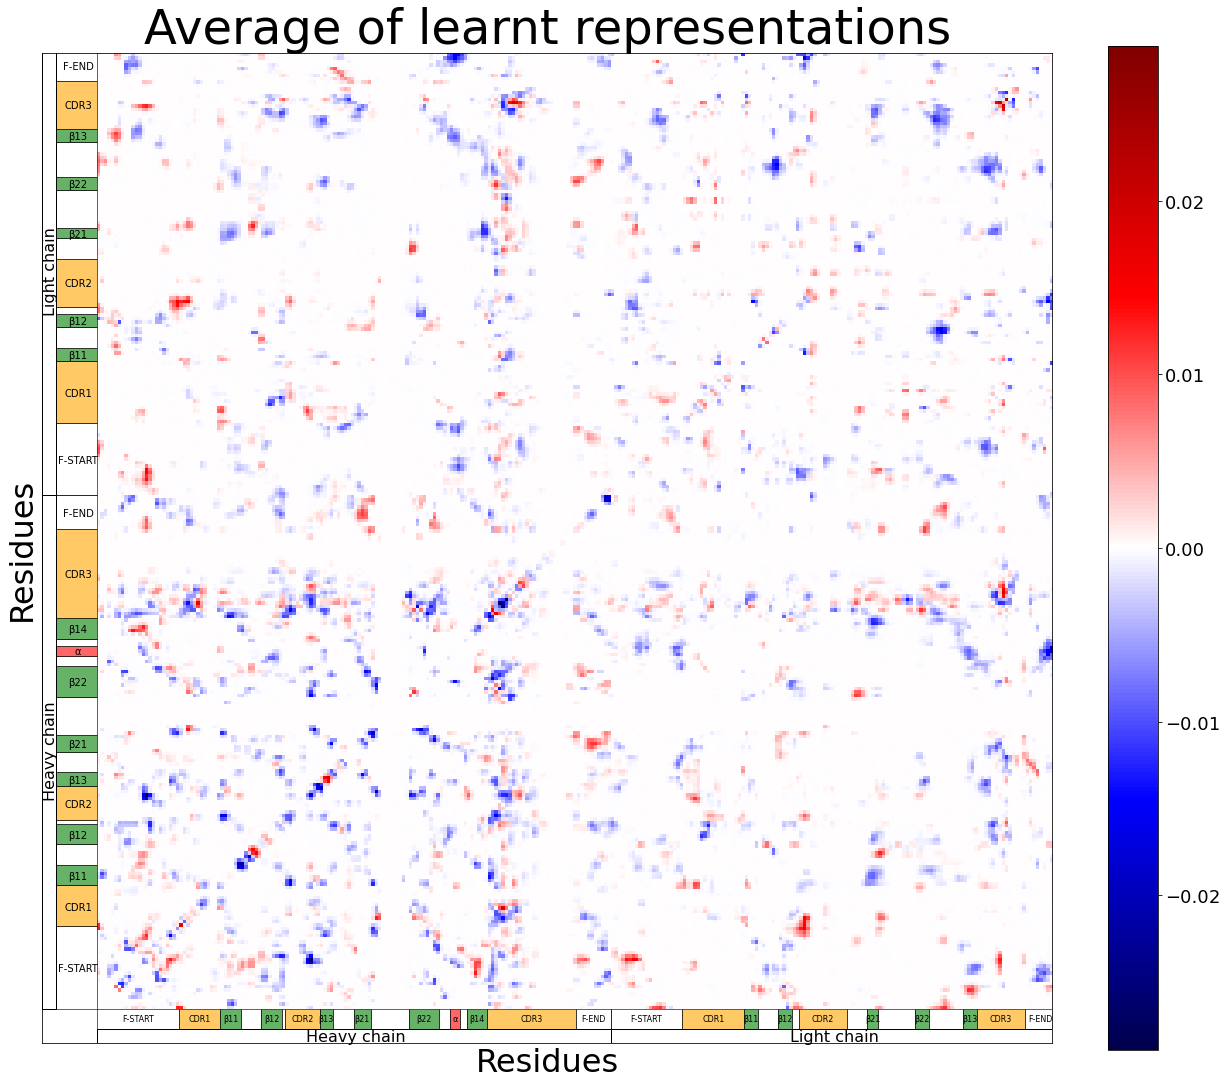

In [80]:
plot_map_with_regions(preprocessed_data, cv2.resize(learnt_filter, dsize=(train_x.shape[2], train_x.shape[2])), 'Average of learnt representations')

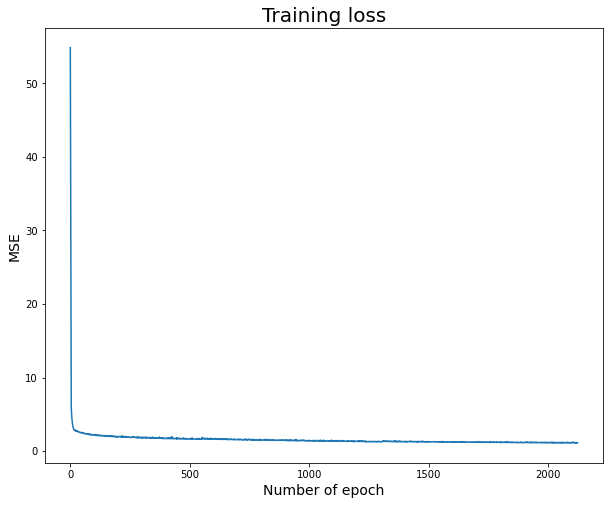

In [81]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

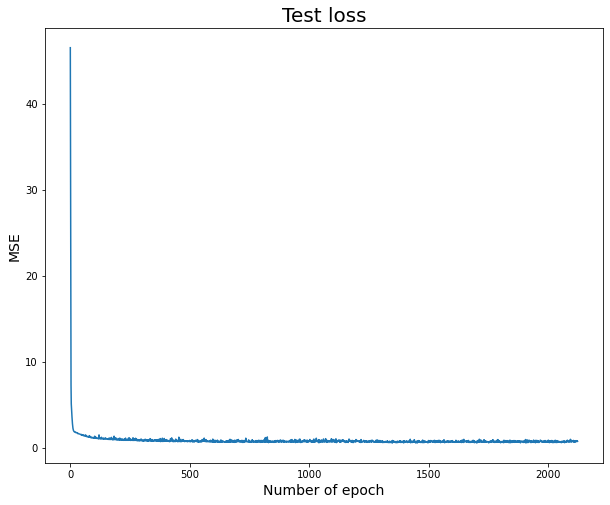

In [82]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i] for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

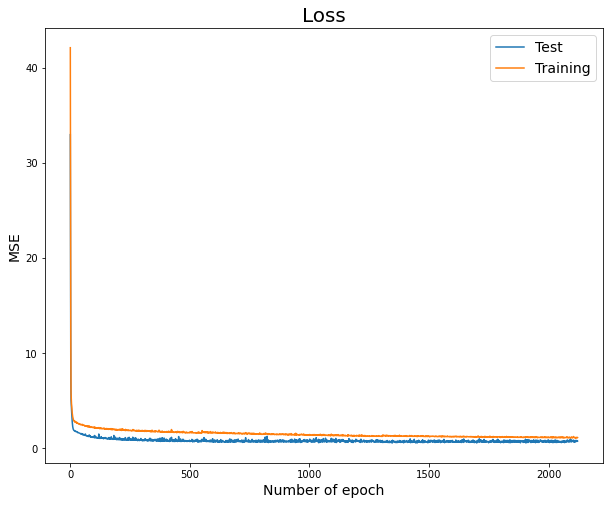

In [83]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[1:][i] for i in range(len(test_losses[1:]))])
plt.plot([train_losses[1:][i] for i in range(len(train_losses[1:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

In [4]:
model(train_x[80:320])[0]

NameError: name 'model' is not defined

In [85]:
train_y[80:120]

tensor([[ -9.0000],
        [ -7.4559],
        [ -7.4559],
        [ -8.6383],
        [ -8.3979],
        [ -5.0232],
        [ -7.4685],
        [ -5.2218],
        [ -7.2840],
        [-10.0000],
        [ -6.9208],
        [ -6.6778],
        [ -7.9208],
        [ -7.9208],
        [ -8.7645],
        [-11.3372],
        [ -3.6990],
        [ -5.3979],
        [ -7.2757],
        [-10.3010],
        [ -7.6990],
        [ -9.3468],
        [ -7.9586],
        [ -7.6990],
        [ -8.4202],
        [ -8.7447],
        [ -5.3979],
        [ -7.6990],
        [ -6.5200],
        [ -7.7696],
        [ -7.8861],
        [ -8.3010],
        [ -9.2218],
        [ -8.3010],
        [ -8.5686],
        [ -8.2048],
        [ -8.0000],
        [ -9.2218],
        [ -7.1135],
        [ -6.2218]])

In [76]:
##### Uncomment the following lines to save a checkpoint

path = '../checkpoints/model_' + regions + '_epochs_' + str(len(train_losses)) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
save_checkpoint(path, model, optimiser, train_losses, test_losses)
np.save('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(len(train_losses))+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy', learnt_filter)

In [12]:
##### Uncomment the following lines to load a checkpoint

from antipasti.utils.torch_utils import load_checkpoint
#
nf_chckpt = 2
pool_chckpt = 1
k_chckpt = 4
ep_chckpt = 1306

path = '../checkpoints/model_' + regions + '_epochs_' + str(ep_chckpt) + '_modes_' + str(modes) + '_pool_' + str(pool_chckpt) + '_filters_' + str(nf_chckpt) + '_size_' + str(k_chckpt) + '.pt'
model,optimiser,_,train_losses, test_losses = load_checkpoint(path, input_shape)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
